# How Factors Influencing Crowd Engagement with News Differ Around the Globe

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import praw
from goose3 import Goose
import matplotlib.pyplot as plt
import pysenti
from sentence_transformers import SentenceTransformer, util
from scipy import stats
import datetime

### Dataset Generation

To construct the datasets, we have implemented the `SubredditDataset` class with all necessary functions for fetching, transforming and cleaning the data. Using a class will make it easier to apply the same scripts to a wide variety of subreddits. We will use the [Python Reddit API Wrapper (PRAW)](https://praw.readthedocs.io/en/stable/index.html) to fetch the posts from our desired subreddits.

Objects of the `SubredditDataset` class have two attributes.
1. `df`: A Pandas DataFrame holding the dataset
2. `path`: The path (string) to where the CSV corresponding to `df` is stored locally

The constructor takes in one required parameter `subreddit` (a string holding the subreddit to be read) and an optional parameter `source`. If `source` is not passed in or is `None`, the constructor will generate the dataset from scratch. Otherwise, `source` holds the path to an existing CSV file with the data for that subreddit and the constructor will load the CSV at `source`.

When generating a dataset, the following steps are taken:
1. Load raw data from Reddit using PRAW as Pandas DataFrame with the following columns:
    - `title`: the title of the post
    - `subreddit`: the subreddit the post belongs to
    - `score`: the number of upvotes minus the number of downvotes received by the post 
    - `id`: a unique identifier for the post 
    - `url`: the URL linked in the post
    - `comms_num`: the number of comments on the post
    - `created`: the date/time at which the post was made (in UTC time zone, represented in Unix time) 
    -  `body`: the body of the Reddit post
2. Calculate the total activity on the post. We define the "total activity on a post" as the sum of its score and number of comments made on it.
3. Fetch the original titles of the articles linked in the posts using the `extract` function in the [Python Goose3 library](https://goose3.readthedocs.io/en/latest/).
4. Vectorize the post title and original title for each article using SentenceTransformer's `all-MiniLM-L6-v2` model and compare the similarity of the embeddings using cosine distance.
5. Determine the sentiment of the articles in the dataset using the [Python-SentiStrength](https://github.com/hykilpikonna/PySenti) library. In this step, each article will be given a score on a scale of -5 (extremely negative) to +5 (extremely positive).
6. Save the DataFrame locally as a CSV for later use.

The final dataset includes the 8 columns mentioned above as well as the following:
- `activity`: the total activity of each article (as defined in Step 2 above)
- `article_title`: the original title of each article
- `headline_changed`: a boolean variable which is True if the post title is the same as the original article title, and False otherwise
- `title_cos_similarity`: the cosine distance between the post title and the original article title (calculated in Step 4 above)
- `sentiment`: the sentiment score assigned to each article (determined in Step 5 above)

**Preprocessing Measures:** Not all posts read by the API are included in our dataset. Any posts without links, linked articles that have paywalls and any posts that cannot be parsed by PRAW (e.g., due to improper formatting of date, etc.) are excluded from our analyses.

In [2]:
class SubredditDataset():
    def __init__(self, subreddit, source=None):
        """
        This is the constructor for the SubredditDataset class.

        Parameters:
            subreddit: str
                The subreddit whose data will be analyzed
            source: None or str
                The path of the CSV containing the data if it has been fetched before. 
                If source is None, dataset will be generated from scratch
        """
        if source != None: # data has been fetched before and is saved locally
            self.df = pd.read_csv(source) # load saved data
            self.path = source
        else: # data has not been fetched before or is not saved locally
            self.df = self.generate_subreddit_dataset(subreddit) # generate dataset from scratch
            self.path = subreddit + '_praw.csv' 

    def generate_subreddit_dataset(self, sr):
        """
        This function will generate a Pandas DataFrame df holding the relevant data
        from subreddit sr.

        Parameters:
            sr: str
                The subreddit whose data will be fetched
        """
        # Get log-in credentials to access Reddit via PRAW
        reddit = self.get_reddit_credentials()

        # Fetch using PRAW and fill dictionary with returned data
        wn_subreddit = reddit.subreddit(sr).hot(limit=1000)
        dict =        { "title":[],
                        "subreddit":[],
                        "score":[], 
                        "id":[], 
                        "url":[], 
                        "comms_num": [], 
                        "created": [], 
                        "body":[]}
        dict = { "title":[],
                        "subreddit":[],
                        "score":[], 
                        "id":[], 
                        "url":[], 
                        "comms_num": [], 
                        "created": [], 
                        "body":[]}
        for submission in wn_subreddit:
            dict["title"].append(submission.title)
            dict['subreddit'].append(submission.subreddit)
            dict["score"].append(submission.score)
            dict["id"].append(submission.id)
            dict["url"].append(submission.url)
            dict["comms_num"].append(submission.num_comments)
            dict["created"].append(submission.created)
            dict["body"].append(submission.selftext)

        df = pd.DataFrame(dict) # save raw dataset as DataFrame

        df['activity'] = df['score'] + df['comms_num']

        df = self.fetch_article_titles(df) # use Goose to fetch original titles of articles linked in Reddit posts

        df['headline_changed'] = (df['title'] != df['article_title']) # add column storing whether

        df = self.calculate_title_similarities(df) # calculate cosine similarities between post titles and article titles

        df = self.fetch_article_sentiments(df) # determine sentiments of articles

        df.to_csv(sr+'_praw.csv', index=False) # save DataFrame locally

        return df

    def get_reddit_credentials(self):
        """
        This function initializes the log-in credentials to access Reddit posts via PRAW.
        """
        # Note: All credentials below have been removed for security.

        reddit = praw.Reddit(client_id='_____', 
                        client_secret='_____', 
                        user_agent='_____', 
                        username='_____', 
                        password='_____')
        return reddit

    def fetch_article_titles(self, df):
        """
        This function fetches the article titles of all news stories in the dataset `df`.
        """

        def get_article_title(url):
            g = Goose()
            # Extract article using URL
            # Try/Except to exclude any articles behind paywall (title cannot be extracted by API)
            try:
                article = g.extract(url=url)
            except:
                return None
            return article.title

        df['article_title'] = df['url'].apply(get_article_title) # get titles of articles in all rows

        df = df.dropna(subset=['article_title']) # remove any rows for articles behind paywall
        
        return df

    def fetch_article_sentiments(self, df):
        """
        This function computes the sentiment of all articles in the dataset `df`.
        """
        
        def get_article_content(url):
            """
            This function retreives the body of the article at link `url`.
            """
            g = Goose()
            # Extract article using URL
            # Try/Except to exclude any articles behind paywall (title cannot be extracted by API)
            try:
                article = g.extract(url=url)
            except:
                return None # if article is behind paywall
            return article.cleaned_text

        def get_article_sentiment(url):
            """
            This function returns the sentiment value (between -5 and +5)
            of the article at link `url`.
            """
            try:
                article_content = get_article_content(url) # retreive body of article
                if article_content == None: # If article cannot be parsed/behind paywall
                    return np.nan
                s = pysenti.get_senti(article_content) # retrieve sentiment
            except:
                return np.nan 
            return s.scale()
        
        df['sentiment'] = df['url'].apply(get_article_sentiment) # find sentiment of articles in all rows
        df = df.dropna(subset=['sentiment']) # remove any rows for articles behind paywall

        return df

    def calculate_title_similarities(self, df):
        """
        This function calculates the cosine similarity between the Reddit post title
        and the original title of the article linked in the post across all rows in
        the dataset `df`.
        """

        model = SentenceTransformer('all-MiniLM-L6-v2') # pre-trained model
        df['title_cos_similarity'] = np.nan # create new column to store similarities

        # Iterate row-by-row and compute cosine distances.
        for i, row in df.iterrows():
            # vectorize titles
            post_title_embedding = model.encode(row['title'])
            article_title_embedding  = model.encode(row['article_title'])

            cosine_score = util.cos_sim(post_title_embedding, article_title_embedding) # compute cosine similarity
            df.at[i, 'title_cos_similarity'] = cosine_score.numpy()[0]

        return df

Let us now generate the datasets required for our analysis. In order to get a diverse set of insights from users around the globe, the subreddits we will explore are:
- [r/canadanews](https://reddit.com/r/canadanews)
- [r/usnews](https://reddit.com/r/usanews)
- [r/uknews](https://reddit.com/r/uknews)
- [r/EUnews](https://reddit.com/r/EUnews)
- [r/ausnews](https://reddit.com/r/ausnews)
- [r/asianews](https://reddit.com/r/asianews)

In [ ]:
canada_news = SubredditDataset('canadanews')
usa_news = SubredditDataset('usanews')
uk_news = SubredditDataset('uknews')
eu_news = SubredditDataset('EUnews')
aus_news = SubredditDataset('ausnews')
asia_news = SubredditDataset('asianews')

Now that we generated the datasets, let us re-load them from their saved CSV files.

In [3]:
canada_news = SubredditDataset(subreddit='canadanews', source='canadanews_praw.csv')
usa_news = SubredditDataset(subreddit='usanews', source='usanews_praw.csv')
uk_news = SubredditDataset(subreddit='uknews', source='uknews_praw.csv')
eu_news = SubredditDataset(subreddit='EUnews', source='EUnews_praw.csv')
aus_news = SubredditDataset(subreddit='ausnews', source='ausnews_praw.csv')
asia_news = SubredditDataset(subreddit='asianews', source='asianews_praw.csv')

### Initial Data Exploration

Let us look at the distributions of all the variables in each dataset.

**Canada News**

In [6]:
canada_news.df.head()

,title,subreddit,score,id,url,comms_num,created,body,activity,article_title,headline_changed,title_cos_similarity,sentiment
0,King Charles to be featured on new coins circu...,canadanews,0,17uzow8,https://www.cbc.ca/news/canada/manitoba/king-c...,1,1699958959,NaN,1,King Charles to be featured on new coins circu...,True,0.033532,0
1,'Vile antisemitic attack:' Police investigatin...,canadanews,6,17su8nc,https://www.cp24.com/news/vile-antisemitic-att...,12,1699708826,NaN,18,'Vile antisemitic attack:' Police investigatin...,False,0.000000,-2
2,Hong Kong activists in Canada want hotline due...,canadanews,7,17stdhp,https://www.theglobeandmail.com/canada/article...,0,1699705671,NaN,7,Hong Kong activists in Canada want hotline due...,False,0.000000,-2
3,Should Canada ban smoking tobacco? Expert weig...,canadanews,64,17sbrwj,https://www.ctvnews.ca/health/should-canada-ba...,275,1699644711,NaN,339,Should Canada ban smoking tobacco? Expert weig...,False,0.000000,0
4,Canadians should be ready for rates to stay hi...,canadanews,140,17s5aqs,https://www.theglobeandmail.com/business/artic...,93,1699626929,NaN,233,Canadians should be ready for rates to stay hi...,False,0.000000,-1


In [7]:
canada_news.df.describe()

,score,comms_num,created,activity,title_cos_similarity,sentiment
count,419.000000,419.000000,4.190000e+02,419.000000,419.000000,419.000000
mean,41.331742,14.892601,1.645630e+09,56.224344,0.201918,-0.474940
std,119.070994,65.171217,3.882211e+07,166.728663,0.314373,0.986132
min,0.000000,0.000000,1.567992e+09,0.000000,0.000000,-3.000000
25%,6.500000,0.000000,1.615503e+09,9.000000,0.000000,-1.000000
50%,17.000000,2.000000,1.645197e+09,20.000000,0.000000,0.000000
75%,35.000000,6.000000,1.682522e+09,41.000000,0.349360,0.000000
max,1183.000000,817.000000,1.699959e+09,1678.000000,1.000000,2.000000


C:\Users\anind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:xlabel='score', ylabel='score'>,
        <AxesSubplot:xlabel='comms_num', ylabel='score'>,
        <AxesSubplot:xlabel='activity', ylabel='score'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='score'>,
        <AxesSubplot:xlabel='sentiment', ylabel='score'>],
       [<AxesSubplot:xlabel='score', ylabel='comms_num'>,
        <AxesSubplot:xlabel='comms_num', ylabel='comms_num'>,
        <AxesSubplot:xlabel='activity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='sentiment', ylabel='comms_num'>],
       [<AxesSubplot:xlabel='score', ylabel='activity'>,
        <AxesSubplot:xlabel='comms_num', ylabel='activity'>,
        <AxesSubplot:xlabel='activity', ylabel='activity'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='activity'>,
        <AxesSubplot:xlabel='sentiment', ylabel='activity'>],
       [<AxesSubplot:xlabel='score', ylabel='title_cos_similarity'>,
     

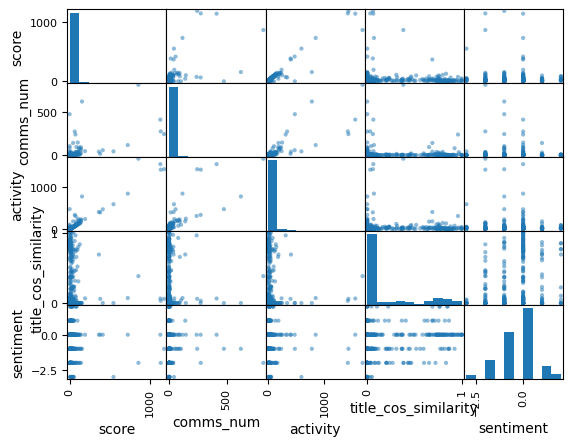

In [8]:
pd.plotting.scatter_matrix(canada_news.df[['score', 'comms_num', 'activity', 'title_cos_similarity', 'sentiment']])

**USA News**

In [9]:
usa_news.df.describe()

,score,comms_num,created,activity,title_cos_similarity,sentiment
count,551.000000,551.000000,5.510000e+02,551.000000,551.000000,551.000000
mean,157.373866,25.232305,1.696174e+09,182.606171,0.073106,-0.883848
std,635.435494,105.141673,2.815650e+06,724.973812,0.174176,1.018525
min,0.000000,0.000000,1.691071e+09,0.000000,0.000000,-3.000000
25%,2.000000,0.000000,1.693764e+09,2.000000,0.000000,-2.000000
50%,5.000000,0.000000,1.696438e+09,6.000000,0.000000,-1.000000
75%,17.000000,2.000000,1.698846e+09,19.000000,0.049260,0.000000
max,7459.000000,1124.000000,1.700098e+09,7949.000000,0.906239,2.000000


C:\Users\anind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:xlabel='score', ylabel='score'>,
        <AxesSubplot:xlabel='comms_num', ylabel='score'>,
        <AxesSubplot:xlabel='activity', ylabel='score'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='score'>,
        <AxesSubplot:xlabel='sentiment', ylabel='score'>],
       [<AxesSubplot:xlabel='score', ylabel='comms_num'>,
        <AxesSubplot:xlabel='comms_num', ylabel='comms_num'>,
        <AxesSubplot:xlabel='activity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='sentiment', ylabel='comms_num'>],
       [<AxesSubplot:xlabel='score', ylabel='activity'>,
        <AxesSubplot:xlabel='comms_num', ylabel='activity'>,
        <AxesSubplot:xlabel='activity', ylabel='activity'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='activity'>,
        <AxesSubplot:xlabel='sentiment', ylabel='activity'>],
       [<AxesSubplot:xlabel='score', ylabel='title_cos_similarity'>,
     

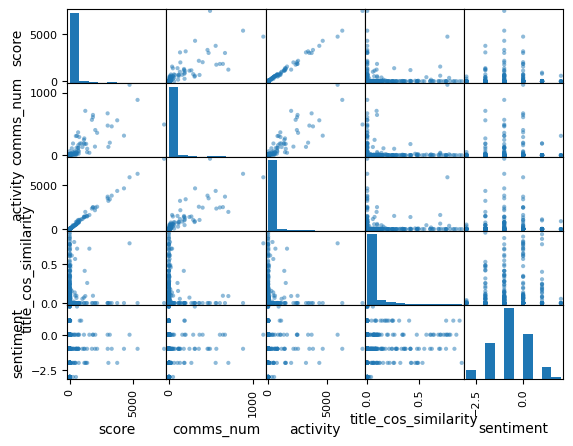

In [10]:
pd.plotting.scatter_matrix(usa_news.df[['score', 'comms_num', 'activity', 'title_cos_similarity', 'sentiment']])

**UK News**

In [11]:
uk_news.df.describe()

,score,comms_num,created,activity,title_cos_similarity,sentiment
count,67.000000,67.000000,6.700000e+01,67.000000,67.000000,67.000000
mean,63.358209,43.208955,1.693039e+09,106.567164,0.176478,0.044776
std,128.719298,90.172484,9.007863e+06,191.138156,0.254464,1.284321
min,0.000000,0.000000,1.663517e+09,0.000000,0.000000,-3.000000
25%,2.000000,0.000000,1.693979e+09,4.000000,0.000000,-1.000000
50%,8.000000,4.000000,1.696222e+09,14.000000,0.068619,0.000000
75%,78.500000,49.000000,1.698229e+09,137.000000,0.205101,1.000000
max,840.000000,600.000000,1.699458e+09,1056.000000,1.000000,3.000000


C:\Users\anind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:xlabel='score', ylabel='score'>,
        <AxesSubplot:xlabel='comms_num', ylabel='score'>,
        <AxesSubplot:xlabel='activity', ylabel='score'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='score'>,
        <AxesSubplot:xlabel='sentiment', ylabel='score'>],
       [<AxesSubplot:xlabel='score', ylabel='comms_num'>,
        <AxesSubplot:xlabel='comms_num', ylabel='comms_num'>,
        <AxesSubplot:xlabel='activity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='sentiment', ylabel='comms_num'>],
       [<AxesSubplot:xlabel='score', ylabel='activity'>,
        <AxesSubplot:xlabel='comms_num', ylabel='activity'>,
        <AxesSubplot:xlabel='activity', ylabel='activity'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='activity'>,
        <AxesSubplot:xlabel='sentiment', ylabel='activity'>],
       [<AxesSubplot:xlabel='score', ylabel='title_cos_similarity'>,
     

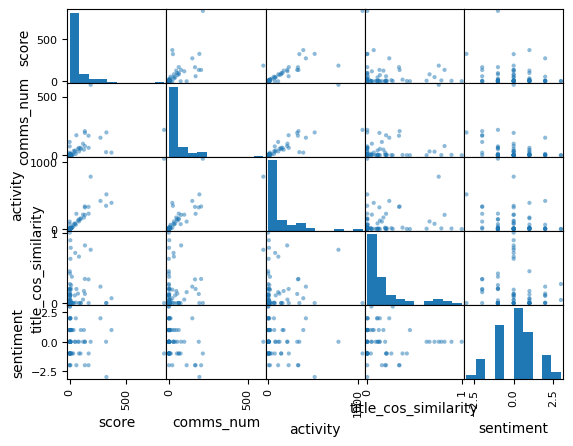

In [12]:
pd.plotting.scatter_matrix(uk_news.df[['score', 'comms_num', 'activity', 'title_cos_similarity', 'sentiment']])

**EU News**

In [13]:
eu_news.df.describe()

,score,comms_num,created,activity,title_cos_similarity,sentiment
count,589.000000,589.000000,5.890000e+02,589.000000,589.000000,589.000000
mean,7.983022,0.502547,1.694778e+09,8.485569,0.175430,-0.837012
std,6.118144,1.500140,3.516122e+06,6.888214,0.207307,0.976208
min,0.000000,0.000000,1.688636e+09,0.000000,0.000000,-4.000000
25%,4.000000,0.000000,1.691511e+09,4.000000,0.000000,-1.000000
50%,6.000000,0.000000,1.695204e+09,7.000000,0.162037,-1.000000
75%,10.000000,0.000000,1.697727e+09,11.000000,0.277604,0.000000
max,59.000000,20.000000,1.700129e+09,71.000000,1.000000,2.000000


C:\Users\anind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:xlabel='score', ylabel='score'>,
        <AxesSubplot:xlabel='comms_num', ylabel='score'>,
        <AxesSubplot:xlabel='activity', ylabel='score'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='score'>,
        <AxesSubplot:xlabel='sentiment', ylabel='score'>],
       [<AxesSubplot:xlabel='score', ylabel='comms_num'>,
        <AxesSubplot:xlabel='comms_num', ylabel='comms_num'>,
        <AxesSubplot:xlabel='activity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='sentiment', ylabel='comms_num'>],
       [<AxesSubplot:xlabel='score', ylabel='activity'>,
        <AxesSubplot:xlabel='comms_num', ylabel='activity'>,
        <AxesSubplot:xlabel='activity', ylabel='activity'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='activity'>,
        <AxesSubplot:xlabel='sentiment', ylabel='activity'>],
       [<AxesSubplot:xlabel='score', ylabel='title_cos_similarity'>,
     

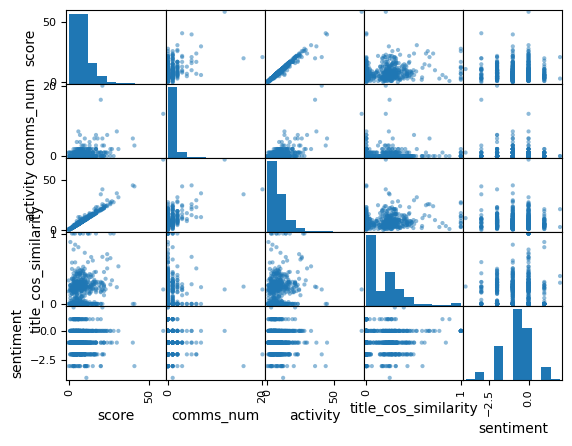

In [14]:
pd.plotting.scatter_matrix(eu_news.df[['score', 'comms_num', 'activity', 'title_cos_similarity', 'sentiment']])

**Australia News**

In [15]:
aus_news.df.describe()

,score,comms_num,created,activity,title_cos_similarity,sentiment
count,340.000000,340.000000,3.400000e+02,340.000000,340.000000,340.000000
mean,18.432353,8.405882,1.678878e+09,26.838235,0.081711,-0.855882
std,21.292003,22.123813,6.077310e+06,39.231711,0.160135,1.038972
min,0.000000,0.000000,1.667950e+09,0.000000,0.000000,-4.000000
25%,6.000000,0.000000,1.674166e+09,8.000000,0.000000,-2.000000
50%,13.000000,2.500000,1.678399e+09,16.000000,0.000000,-1.000000
75%,23.000000,7.000000,1.684102e+09,30.000000,0.066718,0.000000
max,229.000000,285.000000,1.699940e+09,514.000000,0.812945,2.000000


C:\Users\anind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:xlabel='score', ylabel='score'>,
        <AxesSubplot:xlabel='comms_num', ylabel='score'>,
        <AxesSubplot:xlabel='activity', ylabel='score'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='score'>,
        <AxesSubplot:xlabel='sentiment', ylabel='score'>],
       [<AxesSubplot:xlabel='score', ylabel='comms_num'>,
        <AxesSubplot:xlabel='comms_num', ylabel='comms_num'>,
        <AxesSubplot:xlabel='activity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='sentiment', ylabel='comms_num'>],
       [<AxesSubplot:xlabel='score', ylabel='activity'>,
        <AxesSubplot:xlabel='comms_num', ylabel='activity'>,
        <AxesSubplot:xlabel='activity', ylabel='activity'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='activity'>,
        <AxesSubplot:xlabel='sentiment', ylabel='activity'>],
       [<AxesSubplot:xlabel='score', ylabel='title_cos_similarity'>,
     

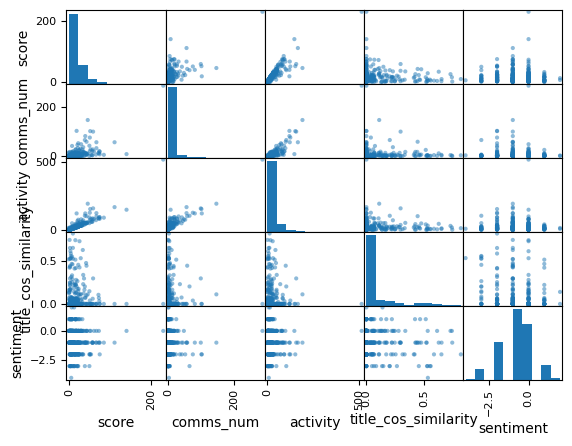

In [16]:
pd.plotting.scatter_matrix(aus_news.df[['score', 'comms_num', 'activity', 'title_cos_similarity', 'sentiment']])

**Asia News**

In [17]:
asia_news.df.describe()

,score,comms_num,created,activity,title_cos_similarity,sentiment
count,64.000000,64.000000,6.400000e+01,64.000000,64.000000,64.000000
mean,1.312500,0.125000,1.444045e+09,1.437500,0.272970,-1.140625
std,0.559904,0.377964,4.994785e+07,0.687184,0.343563,1.412722
min,1.000000,0.000000,1.353491e+09,1.000000,0.000000,-3.000000
25%,1.000000,0.000000,1.426087e+09,1.000000,0.000000,-2.250000
50%,1.000000,0.000000,1.456690e+09,1.000000,0.090677,-1.000000
75%,2.000000,0.000000,1.465325e+09,2.000000,0.646573,0.000000
max,3.000000,2.000000,1.574319e+09,4.000000,0.964056,2.000000


C:\Users\anind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:xlabel='score', ylabel='score'>,
        <AxesSubplot:xlabel='comms_num', ylabel='score'>,
        <AxesSubplot:xlabel='activity', ylabel='score'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='score'>,
        <AxesSubplot:xlabel='sentiment', ylabel='score'>],
       [<AxesSubplot:xlabel='score', ylabel='comms_num'>,
        <AxesSubplot:xlabel='comms_num', ylabel='comms_num'>,
        <AxesSubplot:xlabel='activity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='comms_num'>,
        <AxesSubplot:xlabel='sentiment', ylabel='comms_num'>],
       [<AxesSubplot:xlabel='score', ylabel='activity'>,
        <AxesSubplot:xlabel='comms_num', ylabel='activity'>,
        <AxesSubplot:xlabel='activity', ylabel='activity'>,
        <AxesSubplot:xlabel='title_cos_similarity', ylabel='activity'>,
        <AxesSubplot:xlabel='sentiment', ylabel='activity'>],
       [<AxesSubplot:xlabel='score', ylabel='title_cos_similarity'>,
     

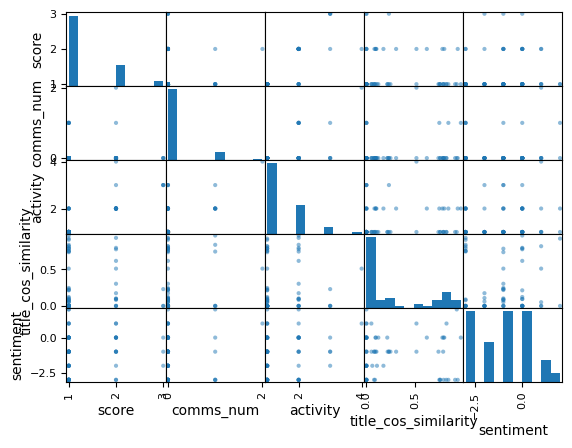

In [18]:
pd.plotting.scatter_matrix(asia_news.df[['score', 'comms_num', 'activity', 'title_cos_similarity', 'sentiment']])

**Overall Initial Thoughts:**

By observing the distributions across the different subreddits, we can see that the final datasets for r/uknews and r/asianews are only about 65 rows long, resulting in sampling bias. Their scatter matrices also appear quite different than the other subreddits (likely as a result of this). Hence, we will exclude these two datasets from our studies.

The other datasets are around the same size (~300-550), have similar value ranges, and appear to have similar relationships among features. We will investigate them further in this study.

*Updated List of Subreddits Analyzed:*
- [r/canadanews](https://reddit.com/r/canadanews)
- [r/usnews](https://reddit.com/r/usanews)
- [r/EUnews](https://reddit.com/r/EUnews)
- [r/ausnews](https://reddit.com/r/ausnews)

### Analyzing Impact of Changing News Article Headline on Crowd Engagment

We will compare the title similarities between posts that are highly engagement with and posts with lower levels of engagement. To measure engagement, we will be looking at activity.

In [24]:
def compare_similarity_means(df, splitby):
    """
    This function uses a T-test to compare the means of the title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        splitby: str
            Can be either 'score', 'comms_num' or 'activity';
            Is the metric by which the data will be split into "high" and "low" groups
    """
    high = df.loc[df[splitby] >= np.percentile(df[splitby], 99)]['title_cos_similarity'] 
    low = df.loc[df[splitby] <= np.percentile(df[splitby], 50)]['title_cos_similarity']
    return stats.ttest_ind(high, low)

In [326]:
canada_ttest = compare_similarity_means(canada_news.df, 'activity')
usa_ttest = compare_similarity_means(usa_news.df, 'activity')
eu_ttest = compare_similarity_means(eu_news.df, 'activity')
aus_ttest = compare_similarity_means(eu_news.df, 'activity')

ttest_df = pd.DataFrame(columns=['Subreddit', 'T-test Statistic', 'p-value'])
ttest_df = ttest_df.append(pd.Series(['canadanews', canada_ttest[0], canada_ttest[1]], index=ttest_df.columns), ignore_index=True)
ttest_df = ttest_df.append(pd.Series(['usanews', canada_ttest[0], usa_ttest[1]], index=ttest_df.columns), ignore_index=True)
ttest_df = ttest_df.append(pd.Series(['EUnews', eu_ttest[0], eu_ttest[1]], index=ttest_df.columns), ignore_index=True)
ttest_df = ttest_df.append(pd.Series(['ausnews', aus_ttest[0], aus_ttest[1]], index=ttest_df.columns), ignore_index=True)

ttest_df

,Subreddit,T-test Statistic,p-value
0,canadanews,-0.589091,0.556424
1,usanews,-0.589091,0.363316
2,EUnews,-0.008271,0.993405
3,ausnews,-0.008271,0.993405


Based on the p-values above, none of the subreddits have a significant difference in title similarity between high and low activity posts. 

To visualize the distributions of title similarities within each subreddit, we will plot three pairs of box plots for each year analyzed.
1. One pair will show the distributions split by score (i.e., one boxplot for posts with scores above the 99th percentile [“high” group] and another for posts with scores in below the 50th percentile [“low” group]).
2. The second pair will show the distributions split by number of comments (i.e., one boxplot for above the 99th percentile [“high”] and another for below the 50th percentile [“low”]).
3. The third pair will show the distributions split by total activity (in the same manner).

In [9]:
def plot_similarity_boxplots(df, subreddit, ax):
    """
    This function plots the boxplots comparing the distribution of title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        subreddit: str, the subreddit being analyzed
        ax: axis on which to plot
    """

    high_activity = df.loc[df['activity'] >= np.percentile(df['activity'], 99)]['title_cos_similarity'] 
    low_activity = df.loc[df['activity'] <= np.percentile(df['activity'], 50)]['title_cos_similarity']
    activity_data = {'High Activity': high_activity, 'Low Activity': low_activity}

    ax.set_title('r/' + subreddit)
    ax.set_ylabel('Cosine Similarity\nBetween Reddit Post Title\nand Article Title')
    ax.boxplot(activity_data.values(), showfliers=False)
    ax.set_xticklabels(activity_data.keys())

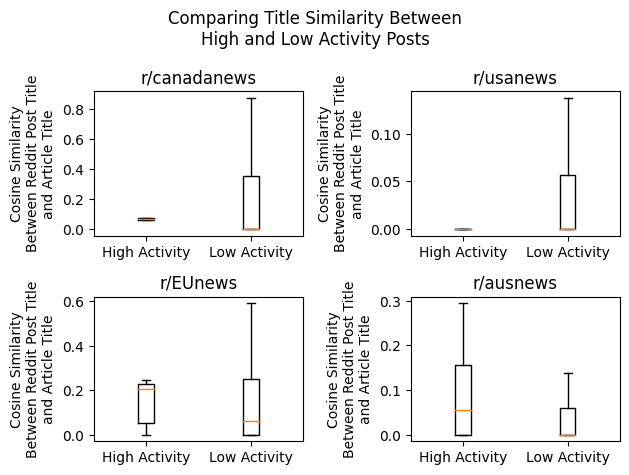

In [351]:
fig, ax = plt.subplots(2,2, tight_layout=True)
fig.suptitle('Comparing Title Similarity Between\nHigh and Low Activity Posts')

plot_similarity_boxplots(canada_news.df, 'canadanews', ax[0][0])
plot_similarity_boxplots(usa_news.df, 'usanews', ax[0][1])
plot_similarity_boxplots(eu_news.df, 'EUnews', ax[1][0])
plot_similarity_boxplots(aus_news.df, 'ausnews', ax[1][1])

The box plots are not very interpretable for all subreddits (especially the high activity groups in r/canadanews and r/usanews). So, we can use violin plots instead to help visualize the distributions.

In [5]:
def plot_similarity_violinplots(df, subreddit, ax):
    """
    This function plots the boxplots comparing the distribution of title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        subreddit: str, the subreddit being analyzed
        ax: axis on which to plot
    """

    high_activity = df.loc[df['activity'] >= np.percentile(df['activity'], 99)]['title_cos_similarity'] 
    low_activity = df.loc[df['activity'] <= np.percentile(df['activity'], 50)]['title_cos_similarity']
    activity_data = {'High Activity': high_activity, 'Low Activity': low_activity}

    ax.set_title('r/' + subreddit)
    ax.set_ylabel('Cosine Similarity\nBetween Reddit Post Title\nand Article Title')
    ax.violinplot(activity_data.values(), showmedians=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(activity_data.keys())

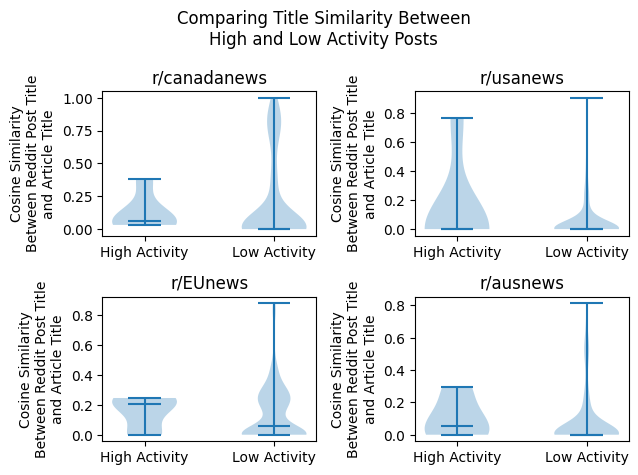

In [353]:
fig, ax = plt.subplots(2,2, tight_layout=True)
fig.suptitle('Comparing Title Similarity Between\nHigh and Low Activity Posts')

plot_similarity_violinplots(canada_news.df, 'canadanews', ax[0][0])
plot_similarity_violinplots(usa_news.df, 'usanews', ax[0][1])
plot_similarity_violinplots(eu_news.df, 'EUnews', ax[1][0])
plot_similarity_violinplots(aus_news.df, 'ausnews', ax[1][1])

We observe that across all the subreddits, the median title cosine similarity of the high activity posts are approximately equal or higher than that of lower activity posts. This contradicts the [Horne and Adali's](https://arxiv.org/abs/1703.10570) findings. This may be due to changes in the way users consume the news over the past decade (since their study was conducted on data in 2012-2013). Additionally, their study was conducted only on the r/worldnews subreddit. Let us construct the same plot on recent posts from r/worldnews.

In [10]:
worldnews = SubredditDataset(subreddit='worldnews', source='worldnews_praw.csv')

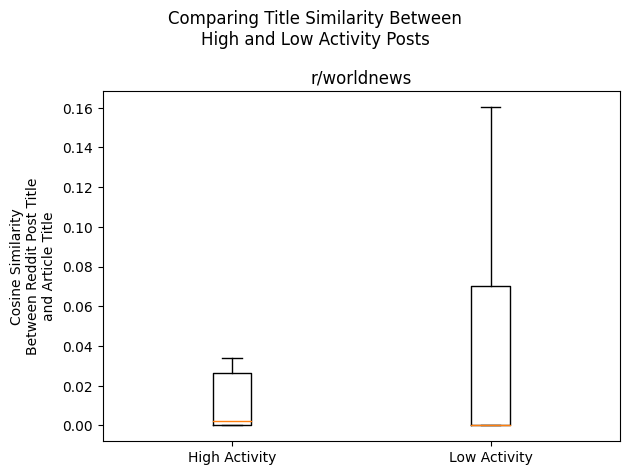

In [11]:
fig, ax = plt.subplots(1,1, tight_layout=True)
fig.suptitle('Comparing Title Similarity Between\nHigh and Low Activity Posts')

plot_similarity_boxplots(worldnews.df, 'worldnews', ax)

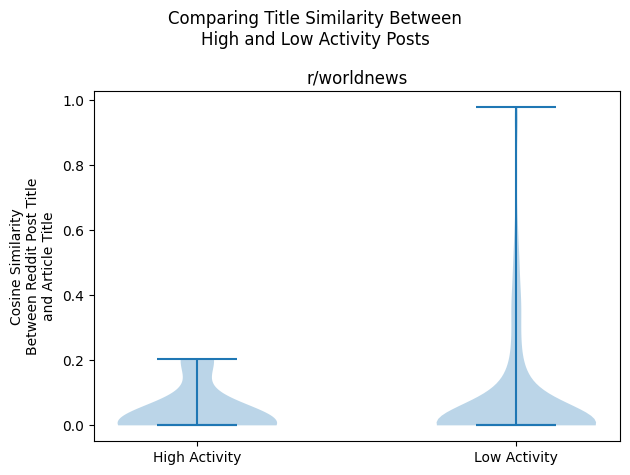

In [13]:
fig, ax = plt.subplots(1,1, tight_layout=True)
fig.suptitle('Comparing Title Similarity Between\nHigh and Low Activity Posts')

plot_similarity_violinplots(worldnews.df, 'worldnews', ax)

With the updated r/worldnews dataset, we saw a similar pattern as with the regional subreddits, suggesting that the way users consume the news has changed since the study.

We observe that across all the subreddits, the median title cosine similarity of the high activity posts are about equal or higher than that of lower activity posts. We also observe that posts with lower engagement have a wider range of title similarity values. We can run the Bartlett test to compare the variances of the different groups.

In [356]:
def compare_similarity_vars(df, splitby):
    """
    This function uses a T-test to compare the means of the title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        splitby: str
            Can be either 'score', 'comms_num' or 'activity';
            Is the metric by which the data will be split into "high" and "low" groups
    """
    high = df.loc[df[splitby] >= np.percentile(df[splitby], 99)]['title_cos_similarity'] 
    low = df.loc[df[splitby] <= np.percentile(df[splitby], 50)]['title_cos_similarity']
    return stats.bartlett(high, low)

In [357]:
canada_ttest = compare_similarity_vars(canada_news.df, 'activity')
usa_ttest = compare_similarity_vars(usa_news.df, 'activity')
eu_ttest = compare_similarity_vars(eu_news.df, 'activity')
aus_ttest = compare_similarity_vars(eu_news.df, 'activity')

btest_df = pd.DataFrame(columns=['Subreddit', 'Bartlett Test Statistic', 'p-value'])
btest_df = btest_df.append(pd.Series(['canadanews', canada_ttest[0], canada_ttest[1]], index=btest_df.columns), ignore_index=True)
btest_df = btest_df.append(pd.Series(['usanews', canada_ttest[0], usa_ttest[1]], index=btest_df.columns), ignore_index=True)
btest_df = btest_df.append(pd.Series(['EUnews', eu_ttest[0], eu_ttest[1]], index=btest_df.columns), ignore_index=True)
btest_df = btest_df.append(pd.Series(['ausnews', aus_ttest[0], aus_ttest[1]], index=btest_df.columns), ignore_index=True)

btest_df

,Subreddit,Bartlett Test Statistic,p-value
0,canadanews,2.916481,0.087679
1,usanews,2.916481,0.007855
2,EUnews,1.494036,0.221591
3,ausnews,1.494036,0.221591


Out of the subreddits analyzed, only r/usanews has a statistically significant difference in variance of title similarity (i.e., high activity posts have a higher variance than low activity posts).

### Analyzing Impact of Article Sentiment on Crowd Engagement

The sentiments of each article have already been determined when constructing the datasets. As part of our initial analysis, let us compare the mean sentiment across groups.

In [63]:
def compare_sentiment_means(df, splitby):
    """
    This function uses a T-test to compare the means of the title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        splitby: str
            Can be either 'score', 'comms_num' or 'activity';
            Is the metric by which the data will be split into "high" and "low" groups
    """
    high = df.loc[df[splitby] >= np.percentile(df[splitby], 99)]['sentiment'] 
    low = df.loc[df[splitby] <= np.percentile(df[splitby], 50)]['sentiment']
    return stats.ttest_ind(high, low)

In [260]:
canada_ttest = compare_sentiment_means(canada_news.df, 'activity')
usa_ttest = compare_sentiment_means(usa_news.df, 'activity')
eu_ttest = compare_sentiment_means(eu_news.df, 'activity')
aus_ttest = compare_sentiment_means(eu_news.df, 'activity')

ttest_df = pd.DataFrame(columns=['Subreddit', 'T-test Statistic', 'p-value'])
ttest_df = ttest_df.append(pd.Series(['canadanews', canada_ttest[0], canada_ttest[1]], index=ttest_df.columns), ignore_index=True)
ttest_df = ttest_df.append(pd.Series(['usanews', canada_ttest[0], usa_ttest[1]], index=ttest_df.columns), ignore_index=True)
ttest_df = ttest_df.append(pd.Series(['EUnews', eu_ttest[0], eu_ttest[1]], index=ttest_df.columns), ignore_index=True)
ttest_df = ttest_df.append(pd.Series(['ausnews', aus_ttest[0], aus_ttest[1]], index=ttest_df.columns), ignore_index=True)

ttest_df

,Subreddit,T-test Statistic,p-value
0,canadanews,-1.203407,0.230155
1,usanews,-1.203407,0.566143
2,EUnews,-2.230939,0.026349
3,ausnews,-2.230939,0.026349


We observed that there was a statistically significant difference in the mean sentiment between the two groups within r/EUnews and r/ausnews. To better understand the data, let us plot boxplots/violinplots to compare the distribution of article sentiment between posts with high engagement to posts with low engagement.

In [306]:
def plot_sentiment_boxplots(df, subreddit, ax):
    """
    This function plots the boxplots comparing the distribution of title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        subreddit: str, the subreddit being analyzed
        ax: axis to plot on
    """
    
    high_activity = df.loc[df['activity'] >= np.percentile(df['activity'], 99)]['sentiment'] 
    low_activity = df.loc[df['activity'] <= np.percentile(df['activity'], 50)]['sentiment']
    activity_data = {'High Activity': high_activity, 'Low Activity': low_activity}

    ax.set_title('r/' + subreddit)
    ax.set_ylabel('Article Sentiment')
    ax.boxplot(activity_data.values(), showfliers=False)
    ax.set_xticklabels(activity_data.keys())

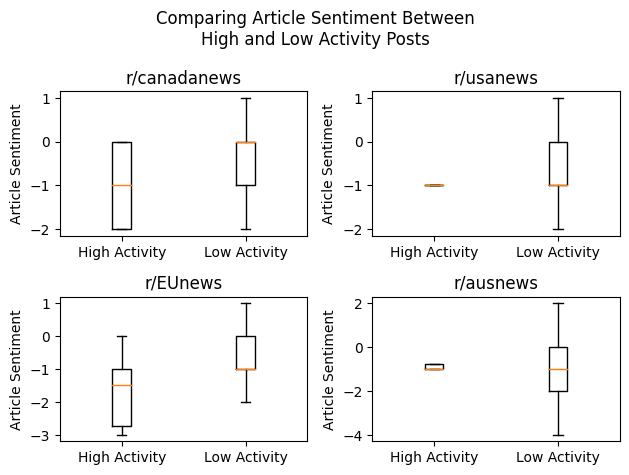

In [307]:
fig, ax = plt.subplots(2,2, tight_layout=True)
fig.suptitle('Comparing Article Sentiment Between\nHigh and Low Activity Posts')

plot_sentiment_boxplots(canada_news.df, 'canadanews', ax[0][0])
plot_sentiment_boxplots(usa_news.df, 'usanews', ax[0][1])
plot_sentiment_boxplots(eu_news.df, 'EUnews', ax[1][0])
plot_sentiment_boxplots(aus_news.df, 'ausnews', ax[1][1])

In [323]:
def plot_sentiment_violinplots(df, subreddit, ax):
    """
    This function plots the violin plots comparing the distribution of title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        subreddit: str, the subreddit being analyzed
        ax: axis to plot on
    """
    high_activity = df.loc[df['activity'] >= np.percentile(df['activity'], 99)]['sentiment'] 
    low_activity = df.loc[df['activity'] <= np.percentile(df['activity'], 50)]['sentiment']
    activity_data = {'High Activity': high_activity, 'Low Activity': low_activity}

    ax.set_title('r/' + subreddit)
    ax.set_ylabel('Article Sentiment')
    ax.violinplot(activity_data.values(), showmedians=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(activity_data.keys())

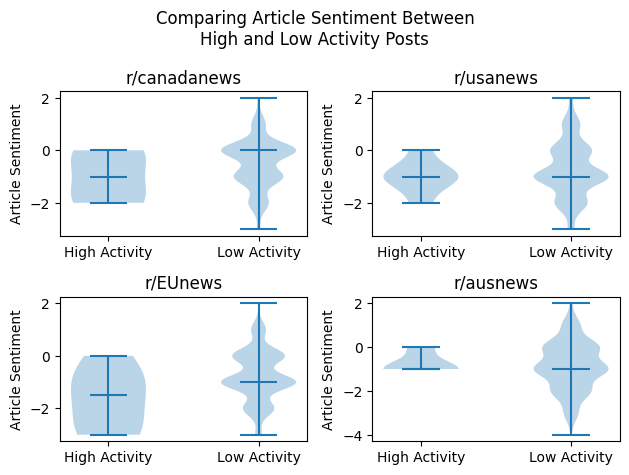

In [324]:
fig, ax = plt.subplots(2,2, tight_layout=True)
fig.suptitle('Comparing Article Sentiment Between\nHigh and Low Activity Posts')

plot_sentiment_violinplots(canada_news.df, 'canadanews', ax[0][0])
plot_sentiment_violinplots(usa_news.df, 'usanews', ax[0][1])
plot_sentiment_violinplots(eu_news.df, 'EUnews', ax[1][0])
plot_sentiment_violinplots(aus_news.df, 'ausnews', ax[1][1])

Posts with higher engagement also tend to link articles with negative or neutral sentiment. Overall, we observe that posts with lower engagement have a wider range of article sentiments. We can run the Bartlett test to compare the variances of the different groups.

In [254]:
def compare_sentiment_vars(df, splitby):
    """
    This function uses a T-test to compare the means of the title similarities between posts
    with high engagement and posts with low engagement.

    Parameters: 
        df: a Pandas DataFrame holding the dataset
        splitby: str
            Can be either 'score', 'comms_num' or 'activity';
            Is the metric by which the data will be split into "high" and "low" groups
    """
    high = df.loc[df[splitby] >= np.percentile(df[splitby], 99)]['sentiment'] 
    low = df.loc[df[splitby] <= np.percentile(df[splitby], 50)]['sentiment']
    return stats.bartlett(high, low)

In [279]:
canada_ttest = compare_sentiment_vars(canada_news.df, 'activity')
usa_ttest = compare_sentiment_vars(usa_news.df, 'activity')
eu_ttest = compare_sentiment_vars(eu_news.df, 'activity')
aus_ttest = compare_sentiment_vars(eu_news.df, 'activity')

btest_df = pd.DataFrame(columns=['Subreddit', 'Bartlett Test Statistic', 'p-value'])
btest_df = btest_df.append(pd.Series(['canadanews', canada_ttest[0], canada_ttest[1]], index=btest_df.columns), ignore_index=True)
btest_df = btest_df.append(pd.Series(['usanews', canada_ttest[0], usa_ttest[1]], index=btest_df.columns), ignore_index=True)
btest_df = btest_df.append(pd.Series(['EUnews', eu_ttest[0], eu_ttest[1]], index=btest_df.columns), ignore_index=True)
btest_df = btest_df.append(pd.Series(['ausnews', aus_ttest[0], aus_ttest[1]], index=btest_df.columns), ignore_index=True)

btest_df

,Subreddit,Bartlett Test Statistic,p-value
0,canadanews,0.034849,0.851912
1,usanews,0.034849,0.186271
2,EUnews,0.590379,0.442273
3,ausnews,0.590379,0.442273


There is no significant difference between the "high" and "low" groups in the variances either. Thus, we cannot make any conclusions regarding the differences in the distribution of sentiments between high and low activity posts other than the fact that posts with high activity have strictly negative or neutral sentiments (out of the sample studied).

### Analyzing Impact of Time of Post on Crowd Engagement

The timestamps are currently in the Unix time format, set to the UTC timezone. We need to convert these to regular datetime format and the appropriate timezone according to the subreddit analyzed. We are only concerned about the hour value in the time stamps as we simply want to estimate what time of day (in the local timezone) the posts were made.

In [147]:
def convert_unix_to_datetime(unix_time):
    """
    This function converts an int value `unix_time` (which holds a time stamp in the Unix format)
    to the datetime format.
    """
    return datetime.datetime.fromtimestamp(unix_time)


def get_hours(df, tz):
    """
    This function calculates the hour in the day (in timezone `tz`) at which each post in the
    dataset `df` was made.

    Parameters:
        df: a Pandas DataFrame holding the subreddit dataset
        tz: str, the timezone to convert all times to
    """
    # Extract hour of posting in UTC timezone 
    df['utc_hour_created'] = df['created'].apply(convert_unix_to_datetime).dt.hour

    # Converts Unix time to UTC datetime format which is then converted to local time
    # Hour is extracted from local time
    df['local_hour_created'] = df['created'].apply(convert_unix_to_datetime).dt.tz_localize('UTC').dt.tz_convert(tz).dt.hour

    return df

As most of the regions analyzed have multiple timezones, we will convert the times in the datasets to the middle timezone in their corresponding region.

We will be using the following timezones for our analysis:
- Canada: `Canada/Central`
- USA: `US/Central`
- EU: `Europe/Berlin`
- Australia: `Australia/Darwin`

In [148]:
canada_news.df = get_hours(canada_news.df, 'Canada/Central')
usa_news.df = get_hours(usa_news.df, 'US/Central')
eu_news.df = get_hours(eu_news.df, 'Europe/Berlin')
aus_news.df = get_hours(aus_news.df, 'Australia/Darwin')

**Analyzing Raw Activity Values**

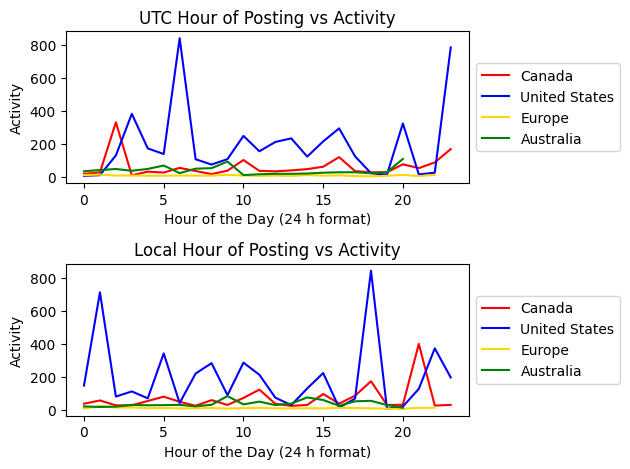

In [177]:
fig, axs = plt.subplots(2,1)

axs[0].set_title('UTC Hour of Posting vs Activity')
axs[0].set_xlabel('Hour of the Day (24 h format)')
axs[0].set_ylabel('Activity')
axs[0].plot(pd.Series(canada_news.df.groupby('utc_hour_created')['activity'].mean().values), label='Canada', color='red')
axs[0].plot(pd.Series(usa_news.df.groupby('utc_hour_created')['activity'].mean().values), label='United States', color='blue')
axs[0].plot(pd.Series(eu_news.df.groupby('utc_hour_created')['activity'].mean().values), label='Europe', color='gold')
axs[0].plot(pd.Series(aus_news.df.groupby('utc_hour_created')['activity'].mean().values), label='Australia', color='green')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))


axs[1].set_title('Local Hour of Posting vs Activity')
axs[1].set_xlabel('Hour of the Day (24 h format)')
axs[1].set_ylabel('Activity')
axs[1].plot(pd.Series(canada_news.df.groupby('local_hour_created')['activity'].mean().values), label='Canada', color='red')
axs[1].plot(pd.Series(usa_news.df.groupby('local_hour_created')['activity'].mean().values), label='United States', color='blue')
axs[1].plot(pd.Series(eu_news.df.groupby('local_hour_created')['activity'].mean().values), label='Europe', color='gold')
axs[1].plot(pd.Series(aus_news.df.groupby('local_hour_created')['activity'].mean().values), label='Australia', color='green')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()


By observing the raw activity values throughout the day, it is difficult to draw any conclusions since the magnitudes between subreddits are so different (e.g., Europe and Australia is much less active than the US, so their plots appear to be around 0). To make the plots more interpretable, we can normalize all the activities for each subreddit (i.e., the highest activity value for each subreddit is set to 1 and the lowest is set to 0).

**Analyzing Normalized Activity Values**

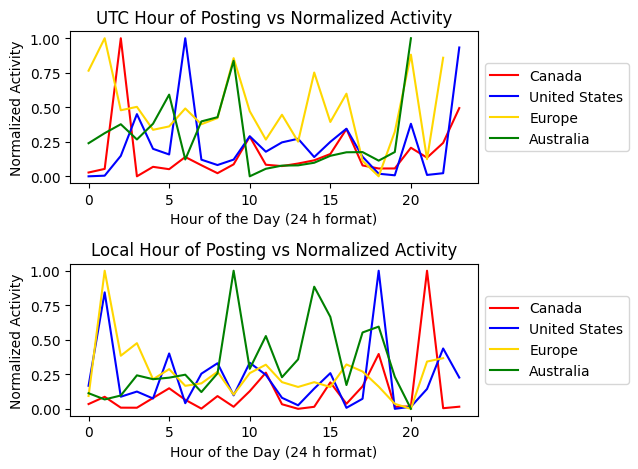

In [180]:
from sklearn.preprocessing import MinMaxScaler

fig, axs = plt.subplots(2,1)

axs[0].set_title('UTC Hour of Posting vs Normalized Activity')
axs[0].set_xlabel('Hour of the Day (24 h format)')
axs[0].set_ylabel('Normalized Activity')
axs[0].plot(pd.Series(MinMaxScaler().fit_transform(canada_news.df.groupby('utc_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='Canada', color='red')
axs[0].plot(pd.Series(MinMaxScaler().fit_transform(usa_news.df.groupby('utc_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='United States', color='blue')
axs[0].plot(pd.Series(MinMaxScaler().fit_transform(eu_news.df.groupby('utc_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='Europe', color='gold')
axs[0].plot(pd.Series(MinMaxScaler().fit_transform(aus_news.df.groupby('utc_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='Australia', color='green')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))


axs[1].set_title('Local Hour of Posting vs Normalized Activity')
axs[1].set_xlabel('Hour of the Day (24 h format)')
axs[1].set_ylabel('Normalized Activity')
axs[1].plot(pd.Series(MinMaxScaler().fit_transform(canada_news.df.groupby('local_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='Canada', color='red')
axs[1].plot(pd.Series(MinMaxScaler().fit_transform(usa_news.df.groupby('local_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='United States', color='blue')
axs[1].plot(pd.Series(MinMaxScaler().fit_transform(eu_news.df.groupby('local_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='Europe', color='gold')
axs[1].plot(pd.Series(MinMaxScaler().fit_transform(aus_news.df.groupby('local_hour_created')['activity'].mean().values.reshape(-1, 1))[:,0]), label='Australia', color='green')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

The normalized activity values are much easier to interpret. When comparing the plots based on hour of posting in UTC, there does not seem to be a very clear pattern between the regions; however, when analyzing the plots based on local time, a loose pattern emerges. It is important to note that since the patterns since the mean time zone was used for local times, the plotted times may be up to 2-3 hours off from the actual hour of posting. Despite this inaccuracy, we observe that in all the regions, there is increased activity on posts posted around 18:00 (6 PM) and 21:00 (11 PM). This may be because users tend to get off from work/school during these times and have some leisurely time to surf Reddit. In Australia, there are also spikes at around 9 AM and 2 PM local time. As these are recorded in the mean time zone, it is possible that these spikes coincide with morning commutes and lunch breaks. 